In [32]:
# from __future__ import print_function, division
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

import random

import _pickle as pickle

from keras_bert import Tokenizer
from keras_bert import load_vocabulary

import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn

from sklearn.manifold import TSNE
import time
import seaborn as sns

    
# %matplotlib inline

In [2]:
%env base eclipse

env: base=eclipse


In [3]:
MAX_SEQUENCE_LENGTH_T = 20 # 100
MAX_SEQUENCE_LENGTH_D = 20 # 500
EMBEDDING_DIM = 300
MAX_NB_WORDS = 20000

In [4]:
# Domain to use
DOMAIN = os.environ['base']
PREPROCESSING = 'bert'
TOKEN = 'bert'
# Dataset paths
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
DATASET = 'data/normalized/{}/{}.csv'.format(DOMAIN, DOMAIN)

In [5]:
df = pd.read_csv(DATASET)

In [6]:
df.head()

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
0,3,normal,RESOLVED,Team,2001-10-10 21:34:00 -0400,2010-05-07 10:28:53 -0400,KM (10/2/2001 5:55:18 PM)\n\tThis PR about the...,[],P5,Platform,FIXED,Sync does not indicate deletion (1GIEN83),2.0
1,1,normal,CLOSED,Team,2001-10-10 21:34:00 -0400,2012-02-09 15:57:47 -0500,- Setup a project that contains a *.gif resour...,[],P3,Platform,FIXED,Usability issue with external editors (1GE6IRL),2.0
2,8,normal,RESOLVED,Team,2001-10-10 21:34:00 -0400,2011-05-17 11:40:32 -0400,"With the current VCM API, a repository adapter...",[],P3,Platform,WONTFIX,how can we support,2.0
3,4,normal,RESOLVED,Team,2001-10-10 21:34:00 -0400,2002-03-01 16:27:31 -0500,- become synchronized with some project in a r...,[],P5,Platform,FIXED,need better error message if catching up over ...,2.0
4,6,normal,RESOLVED,Team,2001-10-10 21:34:00 -0400,2002-02-07 16:29:37 -0500,IResource.setLocal has problems. This method (...,[],P5,Platform,INVALID,API - IResource.setLocal has problems (1G5TC8L),2.0


In [7]:
df_textual = df[['bug_id', 'short_desc', 'description']]
df_textual.loc[:, 'text'] = df['short_desc'] + ". " + df['description']
df_textual.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,bug_id,short_desc,description,text
0,3,Sync does not indicate deletion (1GIEN83),KM (10/2/2001 5:55:18 PM)\n\tThis PR about the...,Sync does not indicate deletion (1GIEN83). KM ...
1,1,Usability issue with external editors (1GE6IRL),- Setup a project that contains a *.gif resour...,Usability issue with external editors (1GE6IRL...
2,8,how can we support,"With the current VCM API, a repository adapter...","how can we support . With the current VCM API,..."
3,4,need better error message if catching up over ...,- become synchronized with some project in a r...,need better error message if catching up over ...
4,6,API - IResource.setLocal has problems (1G5TC8L),IResource.setLocal has problems. This method (...,API - IResource.setLocal has problems (1G5TC8L...


In [8]:
data = df_textual['text'].values

In [9]:
print("Total of data ", len(data))

Total of data  361006


In [10]:
data[:-2]

array(["Sync does not indicate deletion (1GIEN83). KM (10/2/2001 5:55:18 PM)\n\tThis PR about the deletion indicator in the sync viewer being too subtle.\n\tThis would be even more true for someone with vision problems.\n\tNE has good suggestion of using the label of the compare text viewer.\n\tWe may also consider a better icon.\n\tOn to the PR....\n\n- delete file from project\n- synchronize\n- there is no indication that the file has been deleted from the workspace\n- it looks the same as if the file is in the workspace but is empty\n\nNOTES:\n\nKM (8/15/2001 3:37:53 PM)\n\tIt should appear as a rightfacing '-' arrow in the sync view.\n\tSent screen cap to NE requesting clarification.\n\nNE (8/20/01 9:13:38 AM)\n\tThe - in the arrow is clearer when there are other arrows present too (the + and change ones).\n\tOtherwise, it's easy to miss the distinction, especially when the user's attention is focussed\n\ton the text compare panes.\n\tI'd expect the Workspace file: label to indicat

## Bert tokens 

In [11]:
pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
model_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')
token_dict = load_vocabulary(vocab_path)
tokenizer = Tokenizer(token_dict)

### Load bugs

In [12]:
baseline = Baseline(DOMAIN, DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D,
                   token_dict['[CLS]'], token_dict['[SEP]'])
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [13]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

In [14]:
experiment.load_ids()
len(baseline.bug_ids)

Reading bug ids


361006

In [15]:
%%time

experiment.load_bugs(TOKEN)
len(baseline.sentence_dict)


CPU times: user 35.5 s, sys: 3.4 s, total: 38.9 s
Wall time: 38.4 s


In [16]:
ids = []
data = []
for bug_id in tqdm(baseline.bug_set):
    bug = baseline.bug_set[bug_id]
    ids.append(bug_id)
    title = bug['title']
    desc = bug['description']
    data.append("{}\n{}\n".format(title, desc))

In [17]:
# Normalize minutes
# data = [re.sub(r'[0-9]{1,} (min|minutes|minute|m)', 'x time', str(sent)) for sent in data]
# Normalize dates
# data = [re.sub(r'(\d+/\d+/\d+)', 'date', str(sent)) for sent in data]
# Normalize hours
# data = [re.sub(r'(\d+:\d+:\d+)', 'hour', sent) for sent in data]
data = [re.sub(r'(SEP|CLS)', ' ', sent) for sent in data]
# Remove ponctuation
data = [re.sub(r'\W+', ' ', sent) for sent in data]
# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]
# Remove distracting single quotes

In [18]:
data[:2]

[' usa bility issue with external editors 1 ge 6 ir l setup a project that contains a gi f resource release project to cv s edit the gi f resource with an external editor e g paints hop save and close external editor in navigator open the icon resource and verify that your changes are there release project nothing to release in navigator open the icon resource and verify that your changes are still there problem because i never ref resh ed from local the works pace hasn t changed so release didn t find anything however opening the resource with an external editor found the modified file on disk and showed the changes the real problem occurs if release actually finds something to release but you don t spot that some resources are missing this is extremely error prone one of my changes didn t made it into build 110 because of this notes e g 5 23 01 3 00 33 pm release should do a ref resh from local before doing the release moving to vc m km 05 27 01 5 10 19 pm comments from j m in relate

### Tokenization

In [19]:
%%time

def sent_to_words(sentences):
    for sentence in tqdm(sentences):
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['usa', 'bility', 'issue', 'with', 'external', 'editors', 'ge', 'ir', 'setup', 'project', 'that', 'contains', 'gi', 'resource', 'release', 'project', 'to', 'cv', 'edit', 'the', 'gi', 'resource', 'with', 'an', 'external', 'editor', 'paints', 'hop', 'save', 'and', 'close', 'external', 'editor', 'in', 'navigator', 'open', 'the', 'icon', 'resource', 'and', 'verify', 'that', 'your', 'changes', 'are', 'there', 'release', 'project', 'nothing', 'to', 'release', 'in', 'navigator', 'open', 'the', 'icon', 'resource', 'and', 'verify', 'that', 'your', 'changes', 'are', 'still', 'there', 'problem', 'because', 'never', 'ref', 'resh', 'ed', 'from', 'local', 'the', 'works', 'pace', 'hasn', 'changed', 'so', 'release', 'didn', 'find', 'anything', 'however', 'opening', 'the', 'resource', 'with', 'an', 'external', 'editor', 'found', 'the', 'modified', 'file', 'on', 'disk', 'and', 'showed', 'the', 'changes', 'the', 'real', 'problem', 'occurs', 'if', 'release', 'actually', 'finds', 'something', 'to', 'relea

### Lemmatization

In [20]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in tqdm(texts):
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [21]:
%%time

# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB']) #select noun and verb
print(data_lemmatized[:2])


['usa bility issue editor ge setup project contain gi resource release project edit gi resource editor paint hop save close editor navigator open icon resource verify change be release project nothing release navigator open icon resource verify change be problem ref ed work pace hasn change release didn find anything open resource editor find modify file disk show change problem occur release find something release don spot resource be miss be error change didn make build note pm release should do ref resh do release move vc km comment email should do could have set make opt oin should be default setting could be have consider team keep work pace network drive will be side effect will be build run ref resh be complete do work pace run end run release would be builder may be maintain invariant der resource be lea don run builder release will be maintain will release state summary offer ensure consistency release km pm see ge ag win error compare document fail error get log tod', 'open 

## Create the Document-Word matrix

In [22]:
%%time

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10, # minimum reqd occurences of a word 
                             stop_words='english', # remove stop words
                             lowercase=True, # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}', # num chars > 3
                             # max_features=50000,  # max number of uniq words    
                            )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

CPU times: user 20.6 s, sys: 95.9 ms, total: 20.7 s
Wall time: 20.7 s


### Selecting best model 

In [23]:
# https://stackoverflow.com/questions/40115043/no-space-left-on-device-error-while-fitting-sklearn-model
%env JOBLIB_TEMP_FOLDER=/hd/tmp

env: JOBLIB_TEMP_FOLDER=/hd/tmp


In [24]:
%%time

# Define Search Param
search_params = {'n_components': [10, 20, 30], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0, n_jobs=-1)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(data_vectorized)

CPU times: user 1h 14min 1s, sys: 10min 43s, total: 1h 24min 45s
Wall time: 4h 38min 27s


In [25]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 30}
Best Log Likelihood Score:  -68216199.24862832
Model Perplexity:  295.7940014607123


### Dominant topics

In [26]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,dominant_topic
Doc0,0,0.01,0,0.16,0,0,0.05,0,0,0,0.29,0,0.07,0,0.05,0,0,0.07,0,0,0.07,0,0,0.07,0,0,0.05,0,0,0.11,10
Doc1,0,0,0.02,0.22,0,0,0,0,0,0,0.06,0.05,0,0,0,0,0,0,0,0.05,0.23,0,0,0.36,0,0,0,0,0,0,23
Doc2,0,0,0,0.18,0,0.02,0.01,0,0,0.07,0.25,0,0,0,0,0,0,0,0,0,0.06,0,0,0.32,0,0.08,0,0,0,0,23
Doc3,0,0,0,0.29,0,0,0,0.11,0.02,0,0.36,0.03,0,0,0.12,0,0,0,0,0,0.02,0,0.04,0,0,0,0,0,0,0,10
Doc4,0.16,0,0,0.29,0.09,0,0,0,0,0,0.13,0,0,0,0,0,0,0,0,0,0,0.03,0,0,0,0,0.12,0,0,0.16,3
Doc5,0,0,0,0.08,0.03,0,0,0,0,0,0.11,0,0,0.04,0,0,0,0,0,0.03,0,0.6,0,0.02,0,0.01,0,0,0,0.06,21
Doc6,0,0,0,0.13,0,0,0.07,0,0,0,0.29,0,0.02,0,0.32,0,0,0.06,0,0,0.03,0.04,0,0,0,0.01,0,0,0,0,14
Doc7,0,0,0.08,0.19,0,0,0.26,0,0,0,0,0,0,0,0,0,0.02,0,0,0,0,0.12,0,0.04,0,0,0,0,0,0.27,29
Doc8,0,0,0,0.16,0,0,0,0.27,0,0,0.17,0,0,0,0,0,0,0,0,0,0,0.33,0,0,0,0,0,0,0,0,21
Doc9,0.01,0,0,0.37,0,0.17,0.02,0.01,0,0,0,0.02,0,0.01,0,0,0.01,0.01,0,0,0.02,0.08,0,0,0,0.04,0,0,0,0.22,3


### Key words topics

In [29]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords

,aaa,aan,aaron,aba,abandon,abbot,abbreviate,abbreviation,abc,abd,...,zle,zombie,zon,zone,zoo,zoom,zur,zza,zzle,zzy
Topic0,0.033451,0.033347,0.291262,21.008824,0.033346,0.033649,0.034896,0.033346,0.033720,0.033347,...,0.033433,0.033448,0.033348,0.033348,0.954046,0.033345,0.034239,0.033494,0.033386,0.033613
Topic1,0.033345,0.033346,0.033345,0.033346,0.033346,0.033347,0.033346,0.033483,0.033404,0.033346,...,0.033345,0.033346,0.033346,0.033347,0.033347,0.033348,0.033346,0.033345,0.033347,0.033347
Topic2,0.033347,6.732860,71.041752,331.880622,0.033717,0.061720,20.441848,78.195957,0.033381,0.033347,...,0.033454,0.034088,0.067915,0.033346,0.033346,0.033353,0.034069,0.033941,0.033346,0.033345
Topic3,0.033346,0.033346,0.033342,0.033345,3.263593,0.033348,0.033344,0.033347,0.033352,0.033346,...,0.033344,0.046216,0.033351,0.033348,0.033397,0.035280,0.033345,0.033348,0.033379,0.033345
Topic4,0.033445,0.033345,0.033569,0.033347,0.033347,0.033344,0.033344,0.033347,198.131814,0.033347,...,0.033346,0.033345,0.033352,0.033346,0.039228,0.033347,0.033345,0.033354,0.033349,0.033345
Topic5,0.087630,0.033347,0.033346,0.033348,0.033345,0.033344,0.033344,0.033347,0.211769,0.033346,...,0.033345,0.033345,0.033348,0.033346,0.033351,0.033345,0.033345,0.033484,0.033344,0.033345
Topic6,0.033436,0.033515,0.033346,0.033346,0.033348,0.033344,0.033347,0.033346,0.033366,0.033344,...,0.033651,0.033343,0.033347,0.033350,0.033887,0.033346,0.034288,0.033803,0.033397,9.538642
Topic7,0.033702,0.043259,0.033345,0.033645,0.033346,0.033886,0.044258,0.033344,0.034370,0.033347,...,0.033347,0.034720,0.033357,0.033347,0.033372,0.046082,0.033345,0.033347,0.033353,0.033345
Topic8,0.033363,0.033344,0.034134,0.033346,0.033346,0.033348,0.033347,0.033345,0.033612,0.033400,...,0.033346,0.033439,0.033348,33.577472,0.035285,0.033345,0.033345,0.033475,0.033346,0.033349
Topic9,91.413559,32.190981,0.033574,0.053904,0.033346,0.034700,0.033347,0.033345,0.051158,0.033346,...,26.097580,0.052383,0.033348,0.033346,0.083172,0.033625,0.033347,0.034323,0.033358,0.033345


### Get the top 15 words by topic

In [31]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=None, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,line,method,int,string,field,format,column,table,boo,comment,object,code,form,return,col
Topic 1,ser,par,worker,cum,document,lity,word,text,transaction,uti,byte,jax,rule,graph,symbol
Topic 2,let,diagram,https,git,flow,service,doc,mode,documentation,proxy,yad,lyn,bce,execution,user
Topic 3,resource,team,build,pace,persistence,sync,php,builder,sitor,commit,event,cycle,rep,osi,life
Topic 4,set,datum,ele,shell,ion,text,layout,lie,ction,data,ment,display,ite,grid,import
Topic 5,dget,eve,event,action,display,table,ite,send,list,tri,face,handle,ener,bution,dis
Topic 6,ref,act,orin,index,dom,node,chang,ctor,accept,check,perform,ree,extract,cap,peration
Topic 7,select,click,box,drop,press,selection,step,drag,enter,reproduce,explorer,rso,category,check,cross
Topic 8,dial,task,filter,display,button,list,page,preference,control,create,bind,open,cancel,series,tas
Topic 9,point,value,type,code,break,return,element,list,use,chart,ception,exception,add,set,attribute


## Save topics for each bug

In [105]:
X = np.array([row[:-1] for row in df_document_topic.values])
y = np.array([row[-1] for row in df_document_topic.values])
classes = np.unique(y)
X.shape, y.shape, classes.shape, np.asarray(ids).shape

((361006, 30), (361006,), (30,), (361006,))

In [106]:
for i in tqdm(range(len(ids))):
    filename = 'bugs/{}.pkl'.format(ids[i])
    try:
        with open(os.path.join(DIR, filename), 'rb') as f:
            bug = pickle.load(f)
            # Update bugs with topics
            bug['topics'] = X[i]
            bug['topic'] = int(y[i])
            bug['topic_index'] = int(y[i]) - 1
    except:
        bug = {}
    if('topic' not in bug):
        print("Bug of index {} was not saved".format(i))
        continue
    bug_dir = os.path.join(DIR, 'bugs')
    with open(os.path.join(bug_dir, str(ids[i]) + '.pkl'), 'wb') as f:
        pickle.dump(bug, f)

### Visualize topics embed space

In [33]:
def create_tsne(X):
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(X)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    return tsne_results

In [81]:
def plot_clusters(y, tsne_results, classes):
    df_subset = {}
    df_subset['y'] = y
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls", len(classes)),
        data=df_subset,
        legend="full",
        alpha=0.8
    )

In [101]:
X_tsne = X[:1000]
y_tsne = y[:1000]
classes = np.unique(y_tsne)

In [102]:
tsne_results = create_tsne(X_tsne)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.164732
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.238831
[t-SNE] Error after 300 iterations: 1.123482
t-SNE done! Time elapsed: 4.601504325866699 seconds


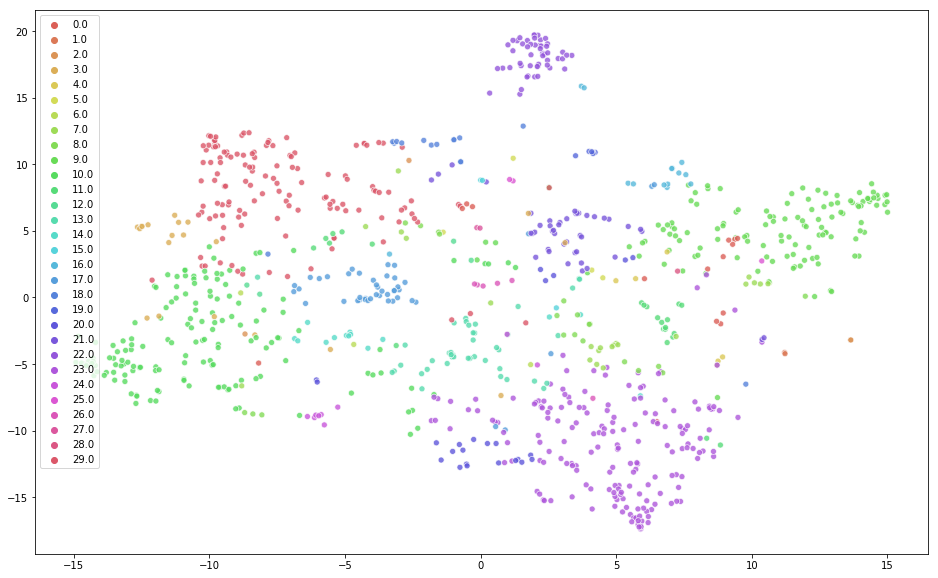

In [103]:
plot_clusters(y_tsne, tsne_results, classes)